In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/sample.csv


In [2]:
import seaborn as sns
import matplotlib as mlt
import math

In [3]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [4]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

In [5]:
import xgboost as xgb

In [6]:
from sklearn.dummy import DummyClassifier

In [7]:
df = pd.read_csv("/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv")
df1 = pd.read_csv("/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv")

<AxesSubplot:>

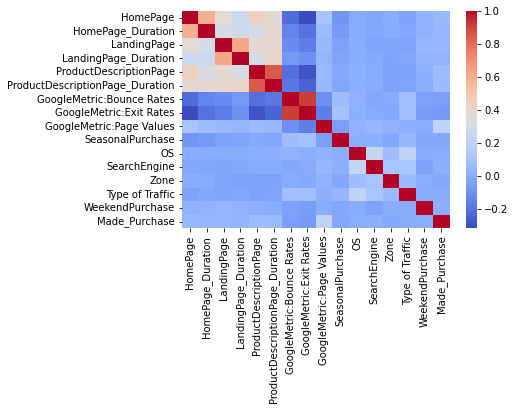

In [8]:
%matplotlib inline
corr_matrix = df.corr()
sns.heatmap(corr_matrix,cmap='coolwarm')

In [9]:
x = np.array(df1.iloc[:,0:20])

In [10]:
X = np.array(df.iloc[:,0:20])
y = np.array(df["Made_Purchase"])

In [11]:
print(X)

print(y)

print(X.shape, y.shape)


[[0.0 0.0 0.0 ... 'Deny' 'Not Specified' 'Other']
 [0.0 0.0 0.0 ... 'Deny' 'Others' 'Married']
 [0.0 0.0 0.0 ... 'ALL' 'Others' 'Married']
 ...
 [2.0 75.6 2.0 ... 'Required' 'Others' 'Single']
 [0.0 0.0 0.0 ... 'Required' 'Not Specified' 'Married']
 [0.0 0.0 0.0 ... 'ALL' 'Diploma' 'Other']]
[False False False ...  True  True  True]
(14731, 20) (14731,)


In [12]:
X_df = df.iloc[:,0:20]
y_df= df['Made_Purchase']

X_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [13]:
X_df_flt1 = df.iloc[:,0:10] 
X_df_flt2 = df.iloc[:,11:15]
X_df_flt = X_df_flt1+X_df_flt2

X_df_flt.columns


Index(['GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates',
       'GoogleMetric:Page Values', 'HomePage', 'HomePage_Duration',
       'LandingPage', 'LandingPage_Duration', 'OS', 'ProductDescriptionPage',
       'ProductDescriptionPage_Duration', 'SearchEngine', 'SeasonalPurchase',
       'Type of Traffic', 'Zone'],
      dtype='object')

In [14]:
X_df_str_clmns = ['Gender'
,'CustomerType'
,'Marital Status'
,'Month_SeasonalPurchase'
,'Cookies Setting'
,'Education']
X_df_str = X_df[X_df_str_clmns]


In [15]:
#print(y_df.info())

print(y_df.isnull().sum())


0


In [16]:
y_df_new = y_df.map({True: 1, False: 0})

y_df_new


0        0
1        0
2        0
3        0
4        0
        ..
14726    1
14727    1
14728    1
14729    1
14730    1
Name: Made_Purchase, Length: 14731, dtype: int64

In [17]:
#X_df['Gender'].unique()

SI = SimpleImputer(strategy = 'most_frequent')
SI.fit(X_df[['Gender']])
X_df['Gender']=SI.fit_transform(X_df[['Gender']])

#print(X_df['Gender'].value_counts())
#print(X_df['Gender'].info())

#X_df['CustomerType'].value_counts()

SI = SimpleImputer(strategy = 'most_frequent')
SI.fit(X_df[['CustomerType']])
X_df['CustomerType']=SI.fit_transform(X_df[['CustomerType']])

#X_df['Month_SeasonalPurchase'].value_counts()

SI = SimpleImputer(strategy = 'most_frequent')
SI.fit(X_df[['Month_SeasonalPurchase']])
X_df['Month_SeasonalPurchase']=SI.fit_transform(X_df[['Month_SeasonalPurchase']])


In [18]:
# KNN Imputation

knn = KNNImputer(n_neighbors = int(math.sqrt(14731)))
for i in X_df_flt.columns:
  X_df[[i]]=knn.fit_transform(X_df[[i]])

#X_df.info()


In [19]:
"""# Fill using Random Forest"""

X_df_cpy = X_df.copy()

oe = OrdinalEncoder()
X_df_cpy[X_df_str_clmns]= oe.fit_transform(X_df_cpy[X_df_str_clmns])

df_missing = X_df_cpy[X_df_cpy.isnull().any(axis=1)]
df_not_missing = X_df_cpy[~X_df_cpy.isnull().any(axis=1)]

#df_missing['Marital Status']



#df_missing

#X_df_cpy

X_train_imp = df_not_missing.drop(['Marital Status', 'Education', 'Cookies Setting'], axis=1)  # Features without missing values
y_train_imp = df_not_missing[['Marital Status', 'Education', 'Cookies Setting']]

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_imp, y_train_imp)

X_missing = df_missing.drop(['Marital Status', 'Education', 'Cookies Setting'], axis=1)  # Features with missing values
y_pred_imp = rf.predict(X_missing)

df_missing[['Marital Status', 'Education', 'Cookies Setting']] = y_pred_imp

df_filled = pd.concat([df_not_missing, df_missing])

df_filled.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14731 entries, 0 to 14726
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14731 non-null  float64
 1   HomePage_Duration                14731 non-null  float64
 2   LandingPage                      14731 non-null  float64
 3   LandingPage_Duration             14731 non-null  float64
 4   ProductDescriptionPage           14731 non-null  float64
 5   ProductDescriptionPage_Duration  14731 non-null  float64
 6   GoogleMetric:Bounce Rates        14731 non-null  float64
 7   GoogleMetric:Exit Rates          14731 non-null  float64
 8   GoogleMetric:Page Values         14731 non-null  float64
 9   SeasonalPurchase                 14731 non-null  float64
 10  Month_SeasonalPurchase           14731 non-null  float64
 11  OS                               14731 non-null  float64
 12  SearchEngine      

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [20]:
mms = MinMaxScaler()
mms_data = mms.fit_transform(df_filled)
mms_scaled_df = pd.DataFrame(mms_data, columns=df_filled.columns)

SS = StandardScaler()
ss_data = SS.fit_transform(df_filled)
ss_scaled_df = pd.DataFrame(ss_data, columns=df_filled.columns)

#MAS = MaxAbsScaler()
#df_filled_3 = MAS.fit_transform(df_filled)

#df_filled.head()

#mms_scaled_df.head()



In [21]:
##dummy_clf = DummyClassifier(strategy="most_frequent")
##dummy_clf.fit(X, y)
##Column2 = dummy_clf.predict(x)
##data_to_submit = pd.DataFrame(Column2)

In [22]:
"""# Test Data"""

X_test_df = df1.iloc[:,0:20]
y_test_df = df1['WeekendPurchase']

print(X_test_df.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         6548 non-null   float64
 1   HomePage_Duration                6544 non-null   float64
 2   LandingPage                      6543 non-null   float64
 3   LandingPage_Duration             6524 non-null   float64
 4   ProductDescriptionPage           6541 non-null   float64
 5   ProductDescriptionPage_Duration  6536 non-null   float64
 6   GoogleMetric:Bounce Rates        6533 non-null   float64
 7   GoogleMetric:Exit Rates          6548 non-null   float64
 8   GoogleMetric:Page Values         6554 non-null   float64
 9   SeasonalPurchase                 6554 non-null   float64
 10  Month_SeasonalPurchase           6541 non-null   object 
 11  OS                               6537 non-null   float64
 12  SearchEngine        

In [23]:
for i in X_df_flt.columns:
  X_test_df[[i]]=knn.fit_transform(X_test_df[[i]])

X_test_df_cpy = X_test_df.copy()

X_test_df_cpy[X_df_str_clmns]= oe.fit_transform(X_test_df_cpy[X_df_str_clmns])

df_test_missing = X_test_df_cpy[X_test_df_cpy.isnull().any(axis=1)]
df_test_not_missing = X_test_df_cpy[~X_test_df_cpy.isnull().any(axis=1)]

X_test_imp = df_test_not_missing.drop(X_df_str_clmns, axis=1)  # Features without missing values
y_test_imp = df_test_not_missing[X_df_str_clmns]

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_test_imp, y_test_imp)

X_test_missing = df_test_missing.drop(X_df_str_clmns, axis=1)  # Features with missing values
y_test_pred_imp = rf.predict(X_test_missing)

df_test_missing[X_df_str_clmns] = y_test_pred_imp

df_test_filled = pd.concat([df_test_not_missing, df_test_missing])

df_test_filled.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 6599 entries, 0 to 6584
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         6599 non-null   float64
 1   HomePage_Duration                6599 non-null   float64
 2   LandingPage                      6599 non-null   float64
 3   LandingPage_Duration             6599 non-null   float64
 4   ProductDescriptionPage           6599 non-null   float64
 5   ProductDescriptionPage_Duration  6599 non-null   float64
 6   GoogleMetric:Bounce Rates        6599 non-null   float64
 7   GoogleMetric:Exit Rates          6599 non-null   float64
 8   GoogleMetric:Page Values         6599 non-null   float64
 9   SeasonalPurchase                 6599 non-null   float64
 10  Month_SeasonalPurchase           6599 non-null   float64
 11  OS                               6599 non-null   float64
 12  SearchEngine        

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [24]:
mms = MinMaxScaler()
mms_test_data = mms.fit_transform(df_test_filled)
mms_test_scaled_df = pd.DataFrame(mms_test_data, columns=df_filled.columns)

ss_test_data = SS.fit_transform(df_test_filled)
ss_test_scaled_df = pd.DataFrame(ss_test_data, columns=df_filled.columns)

SI.fit(y_test_df.dropna().values.reshape(-1, 1))
imputed_values = SI.transform(y_test_df.values.reshape(-1, 1)).flatten()

y_test_df = pd.Series(imputed_values, index=y_test_df.index)

#y_test_df.info()

y_test_df

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6594    1.0
6595    0.0
6596    0.0
6597    1.0
6598    0.0
Length: 6599, dtype: float64

In [25]:
"""# Logistic Regression"""

"""from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg = LogisticRegression(random_state = 26, penalty="l2", solver='liblinear')
model = logreg.fit(ss_scaled_df, y_df_new)
y_pred_log = logreg.predict(ss_test_scaled_df)
y_pred_log_train = logreg.predict(ss_scaled_df)

print("F1 Score Test Data : ", f1_score(y_test_df,y_pred_log))
print("F1 Score Train Data : ", f1_score(y_df_new,y_pred_log_train))

print("Accuracy Test Data : ", accuracy_score(y_test_df,y_pred_log))
print("Accuracy Train Data : ", accuracy_score(y_df_new,y_pred_log_train))
"""


'from sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import train_test_split\n\nlogreg = LogisticRegression(random_state = 26, penalty="l2", solver=\'liblinear\')\nmodel = logreg.fit(ss_scaled_df, y_df_new)\ny_pred_log = logreg.predict(ss_test_scaled_df)\ny_pred_log_train = logreg.predict(ss_scaled_df)\n\nprint("F1 Score Test Data : ", f1_score(y_test_df,y_pred_log))\nprint("F1 Score Train Data : ", f1_score(y_df_new,y_pred_log_train))\n\nprint("Accuracy Test Data : ", accuracy_score(y_test_df,y_pred_log))\nprint("Accuracy Train Data : ", accuracy_score(y_df_new,y_pred_log_train))\n'

In [26]:
"""# Support Vector Machine

from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(ss_scaled_df, y_df_new)
y_pred_svm = classifier.predict(ss_test_scaled_df)
y_pred_svm_train = classifier.predict(ss_scaled_df)

print("Test Data : ", f1_score(y_test_df,y_pred_svm))
print("Train Data : ", f1_score(y_df_new,y_pred_svm_train))

print("Test Data : ", accuracy_score(y_test_df,y_pred_svm))
print("Train Data : ", accuracy_score(y_df_new,y_pred_svm_train))

"""

'# Support Vector Machine\n\nfrom sklearn.svm import SVC\n\nclassifier = SVC(kernel=\'rbf\', random_state = 1)\nclassifier.fit(ss_scaled_df, y_df_new)\ny_pred_svm = classifier.predict(ss_test_scaled_df)\ny_pred_svm_train = classifier.predict(ss_scaled_df)\n\nprint("Test Data : ", f1_score(y_test_df,y_pred_svm))\nprint("Train Data : ", f1_score(y_df_new,y_pred_svm_train))\n\nprint("Test Data : ", accuracy_score(y_test_df,y_pred_svm))\nprint("Train Data : ", accuracy_score(y_df_new,y_pred_svm_train))\n\n'

In [27]:
"""# Naive Bayes
nb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Define the grid search object
nb_cv = GridSearchCV(nb, param_grid=param_grid, cv=5, scoring='f1')

# Fit the data to the grid search object
nb_cv.fit(ss_scaled_df, y_df_new)

# Print the best hyperparameters and the corresponding F1 score
print("Best Hyperparameters: ", nb_cv.best_params_)
print("Best F1 Score: ", nb_cv.best_score_)
"""


'# Naive Bayes\nnb = GaussianNB()\n\nparam_grid = {\n    \'var_smoothing\': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]\n}\n\n# Define the grid search object\nnb_cv = GridSearchCV(nb, param_grid=param_grid, cv=5, scoring=\'f1\')\n\n# Fit the data to the grid search object\nnb_cv.fit(ss_scaled_df, y_df_new)\n\n# Print the best hyperparameters and the corresponding F1 score\nprint("Best Hyperparameters: ", nb_cv.best_params_)\nprint("Best F1 Score: ", nb_cv.best_score_)\n'

In [28]:
nb = GaussianNB(var_smoothing = 1e-9)
nb.fit(ss_scaled_df, y_df_new)
y_pred_nb = nb.predict(ss_test_scaled_df)

In [29]:
"""# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()

# Train Decision Tree Classifer
DTC = DTC.fit(df_filled,y_df_new)

#Predict the response for test dataset
y_pred_DTC = DTC.predict(df_test_filled)
y_pred_DTC_train = DTC.predict(df_filled)

print("Test Data : ", f1_score(y_test_df,y_pred_DTC))
print("Train Data : ", f1_score(y_df_new,y_pred_DTC_train))

print("Test Data : ", accuracy_score(y_test_df,y_pred_DTC))
print("Train Data : ", accuracy_score(y_df_new,y_pred_DTC_train))

#Terrible Classifier, remove before Final Submission
"""

'# Decision Tree Classifier\nfrom sklearn.tree import DecisionTreeClassifier\n\nDTC = DecisionTreeClassifier()\n\n# Train Decision Tree Classifer\nDTC = DTC.fit(df_filled,y_df_new)\n\n#Predict the response for test dataset\ny_pred_DTC = DTC.predict(df_test_filled)\ny_pred_DTC_train = DTC.predict(df_filled)\n\nprint("Test Data : ", f1_score(y_test_df,y_pred_DTC))\nprint("Train Data : ", f1_score(y_df_new,y_pred_DTC_train))\n\nprint("Test Data : ", accuracy_score(y_test_df,y_pred_DTC))\nprint("Train Data : ", accuracy_score(y_df_new,y_pred_DTC_train))\n\n#Terrible Classifier, remove before Final Submission\n'

In [30]:
"""# Random Forest



forest = RandomForestClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1,
                                 n_jobs=2)

forest.fit(df_filled,y_df_new)
y_pred_for = forest.predict(df_test_filled)
y_pred_for_train = DTC.predict(df_filled)

print("Test Data : ", f1_score(y_test_df,y_pred_for))
print("Train Data : ", f1_score(y_df_new,y_pred_for_train))

print("Test Data : ", accuracy_score(y_test_df,y_pred_for))
print("Train Data : ", accuracy_score(y_df_new,y_pred_for_train))
"""

'# Random Forest\n\n\n\nforest = RandomForestClassifier(criterion=\'gini\',\n                                 n_estimators=5,\n                                 random_state=1,\n                                 n_jobs=2)\n\nforest.fit(df_filled,y_df_new)\ny_pred_for = forest.predict(df_test_filled)\ny_pred_for_train = DTC.predict(df_filled)\n\nprint("Test Data : ", f1_score(y_test_df,y_pred_for))\nprint("Train Data : ", f1_score(y_df_new,y_pred_for_train))\n\nprint("Test Data : ", accuracy_score(y_test_df,y_pred_for))\nprint("Train Data : ", accuracy_score(y_df_new,y_pred_for_train))\n'

In [31]:
"""# Gradient Boosting Classifier"""



from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(ss_scaled_df, y_df_new)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(ss_scaled_df, y_df_new)))

gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(ss_scaled_df, y_df_new)
predictions = gb_clf2.predict(ss_test_scaled_df)

print("Test Data : ", f1_score(y_test_df,predictions))
#print("Train Data : ", f1_score(y_df_new,y_pred_for_train))


Learning rate:  0.05
Accuracy score (training): 0.615
Learning rate:  0.075
Accuracy score (training): 0.632
Learning rate:  0.1
Accuracy score (training): 0.647
Learning rate:  0.25
Accuracy score (training): 0.651
Learning rate:  0.5
Accuracy score (training): 0.652
Learning rate:  0.75
Accuracy score (training): 0.652
Learning rate:  1
Accuracy score (training): 0.652
Test Data :  0.18383924754168446


In [32]:
hyperparameters = {
    'learning_rate': lr_list,
    'n_estimators': [20,30,45,50],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=hyperparameters,
    n_iter=50,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search.fit(ss_scaled_df, y_df_new)

# Print the best set of hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'n_estimators': 45, 'max_features': 'sqrt', 'learning_rate': 1}


In [33]:
gb_clf3 = GradientBoostingClassifier(n_estimators=45, learning_rate=1, max_features="sqrt",random_state=42)
gb_clf3.fit(ss_scaled_df, y_df_new)
predictions_2 = gb_clf3.predict(ss_test_scaled_df)

In [34]:
"""model = xgb.XGBClassifier()

# Setting the hyperparameters
params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [20,25,30,40]
}
xgb_cv = GridSearchCV(model, params, scoring='f1', cv=5, n_jobs=-1)
xgb_cv.fit(ss_scaled_df, y_df_new)
"""

"model = xgb.XGBClassifier()\n\n# Setting the hyperparameters\nparams = {\n    'max_depth': [3, 5, 7, 9],\n    'learning_rate': [0.01, 0.1, 0.5, 1],\n    'n_estimators': [20,25,30,40]\n}\nxgb_cv = GridSearchCV(model, params, scoring='f1', cv=5, n_jobs=-1)\nxgb_cv.fit(ss_scaled_df, y_df_new)\n"

In [35]:
'''xgb_model = xgb.XGBClassifier(**xgb_cv.best_params_)
xgb_model.fit(ss_scaled_df, y_df_new)

# Predicting on the test set and evaluating the F1 score
y_pred_xgb = xgb_model.predict(ss_test_scaled_df)
'''

'xgb_model = xgb.XGBClassifier(**xgb_cv.best_params_)\nxgb_model.fit(ss_scaled_df, y_df_new)\n\n# Predicting on the test set and evaluating the F1 score\ny_pred_xgb = xgb_model.predict(ss_test_scaled_df)\n'

In [36]:
#penu = pd.DataFrame(y_pred_log)
#penu = pd.DataFrame(y_pred_svm)
#penu = pd.DataFrame(y_pred_DTC)
#penu = pd.DataFrame(y_pred_for)
#penu = pd.DataFrame(y_pred_nb)
penu = pd.DataFrame(predictions_2)
#penu = pd.DataFrame(y_pred_xgb)
data_to_submit= penu.replace({0:False,1:True})

data_to_submit.head()

,0
0,False
1,False
2,False
3,False
4,False


In [37]:
data_to_submit.index.name="id";
data_to_submit.to_csv('submission.csv', header=["Made_Purchase"])
print("Finished")

Finished
